* Discussions - 
    * check feasibility of a model trained once and able to predict (like train every 7 days). If not - we can train everyday. 
    * Intent of predicting topics is it to show say pvs last week for a topic vs this week. How far out such comparisons need to be made? -- that will decide the date range of training and prediction -- a week is good strat
    * Keep topic words same but test with lesser number of words
    * Not every article needs to be assigned to a topic. so noise part of hdbscan is fine

**Data product options:**

* Technique 1 - train every 7 days
    * PART 1: Check if day-of-week = Monday :: 
        * Take past 7 days (apr 26 till may 02)
        * Train & store file
        * Get yesterday's topics (may 02) and save that 1 day
        
    * PART 2: Else ::
        * Take yesterday's eligible articles
        * Use the saved cluster file and predict
        * save that 1 day
        * Part 2 will be repeated from tues till sunday of a week
        
    * When loop progresses to day = Monday, execute Part 1, then Part 2 and loop goes on 
    
Note: 
* Caveat - We are training on articles which already have labels (through prediction).   
* Save embeddings - so repeating ones need not be calculated. Plus, they can be used as features in other projects

**Environment issue**:
* On 6/11/2021 upgrading transformers messed up the environment (topics). Recreated using req.txt (called topics-env).
* Imp point to note - for umap, hdbcsan to work, numba>-0.50.x Added this to the req.txt
* transformers library version = 4.3.2 -- add this during deployment if going with topic summarization
* Not deleting topics environment, in case other working library versions need to be consulted 

In [1]:
""" Helper imports"""
import re
import joblib
import pandas as pd
import numpy as np
from time import time
from nltk.tokenize import sent_tokenize
from joblib import Parallel, delayed
from sklearn.metrics.pairwise import cosine_similarity

"""Modeling imports"""
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

""" Plotting imports"""
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# remove this later
pd.set_option('max_colwidth', 110)
import warnings
warnings.filterwarnings('ignore')

### Competitor research:
* WSJ uses HDBSCAN - https://medium.com/the-wall-street-journal/staying-on-topic-building-an-automated-topic-model-of-wsj-news-coverage-d4dc4369f71b

In [2]:
from src.util import (c_tf_idf, 
                      extract_top_n_words_per_topic,
                      extract_topic_sizes,
                      topic_cos_sim_metrics,
                      generate_all_cossim_metrics)

In [3]:
import umap
import hdbscan
from sentence_transformers import SentenceTransformer
from hdbscan import validity_index

In [4]:
data_path = '/home/jupyter/bi-topic-modeling/data/' 

STOP_WORDS = pd.read_pickle(data_path + 'forbes_stop_words.pkl')
"q1" in STOP_WORDS

True

In [5]:
results_path = '/home/jupyter/bi-topic-modeling/results/' 
SEED = 42

### --- Data ---

* Train date range Apr 26 (monday) till May 02 (sunday)
* Eligible pool = articles with pvs > 100 on a given day

In [6]:
def get_data(file_name):
    
    df = pd.read_csv(data_path + file_name)

    print("Before Shape:", df.shape)
    print("Unique tiers:", len(df.tier1.unique()))
    
    # Per verdict from EDA, exclude articles less than 100 words
    df["article_length"] = df.clean_body.str.split().apply(len)
    df = df[df["article_length"]>=100]
    print("After Shape:", df.shape)
    
    df.tier1 = df.tier1.fillna('Other')
    df = df.reset_index(drop=True)
    
    return df

In [7]:
# training data set

print("--- apr 25 ---")
apr25 = get_data('processed/train_apr25_over100pvs_processed.csv')
apr25_art_embed = joblib.load("./data/processed/apr25_article_embed_axis0.joblib")
print("Embeds len:", len(apr25_art_embed))

print()
print("--- apr 26 ---")
apr26 = get_data('processed/pred_apr26_over100pvs_processed.csv')
apr26_art_embed = joblib.load("./data/processed/apr26_article_embed_axis0.joblib")
print("Embeds len:", len(apr26_art_embed))

print()
print("--- apr 27 ---")
apr27 = get_data('processed/pred_apr27_over100pvs_processed.csv')
apr27_art_embed = joblib.load("./data/processed/apr27_article_embed_axis0.joblib")
print("Embeds len:", len(apr27_art_embed))

print()
print("--- apr 28 ---")
apr28 = get_data('processed/apr28_over100pvs_processed.csv')
apr28_art_embed = joblib.load("./data/processed/apr28_article_embed_axis0.joblib")
print("Embeds len:", len(apr28_art_embed))

print()
print("--- apr 29 ---")
apr29 = get_data('processed/apr29_over100pvs_processed.csv')
apr29_art_embed = joblib.load("./data/processed/apr29_article_embed_axis0.joblib")
print("Embeds len:", len(apr29_art_embed))

print()
print("--- apr 30 ---")
apr30 = get_data('processed/apr30_over100pvs_processed.csv')
apr30_art_embed = joblib.load("./data/processed/apr30_article_embed_axis0.joblib")
print("Embeds len:", len(apr30_art_embed))

print("--- may 01 ---")
may01 = get_data('processed/may01_over100pvs_processed.csv')
may01_art_embed = joblib.load("./data/processed/may01_article_embed_axis0.joblib")
print("Embeds len:", len(may01_art_embed))

print()
print("--- may 02 ---")
may02 = get_data('processed/may02_over100pvs_processed.csv')
may02_art_embed = joblib.load("./data/processed/may02_article_embed_axis0.joblib")
print("Embeds len:", len(may02_art_embed))

--- apr 25 ---
Before Shape: (3334, 10)
Unique tiers: 31
After Shape: (3327, 11)
Embeds len: 3327

--- apr 26 ---
Before Shape: (4138, 10)
Unique tiers: 31
After Shape: (4128, 11)
Embeds len: 4128

--- apr 27 ---
Before Shape: (4177, 10)
Unique tiers: 31
After Shape: (4167, 11)
Embeds len: 4167

--- apr 28 ---
Before Shape: (4197, 8)
Unique tiers: 31
After Shape: (4186, 9)
Embeds len: 4186

--- apr 29 ---
Before Shape: (4201, 8)
Unique tiers: 31
After Shape: (4188, 9)
Embeds len: 4188

--- apr 30 ---
Before Shape: (3784, 8)
Unique tiers: 31
After Shape: (3771, 9)
Embeds len: 3771
--- may 01 ---
Before Shape: (3052, 8)
Unique tiers: 31
After Shape: (3044, 9)
Embeds len: 3044

--- may 02 ---
Before Shape: (3267, 8)
Unique tiers: 31
After Shape: (3259, 9)
Embeds len: 3259


In [8]:
# testing data set

print()
print("--- may 03 ---")
may03 = get_data('processed/may03_over100pvs_processed.csv')
may03_art_embed = joblib.load("./data/processed/may03_article_embed_axis0.joblib")
print("Embeds len:", len(may03_art_embed))

print()
print("--- may 04 ---")
may04 = get_data('processed/may04_over100pvs_processed.csv')
may04_art_embed = joblib.load("./data/processed/may04_article_embed_axis0.joblib")
print("Embeds len:", len(may04_art_embed))

print()
print("--- may 05 ---")
may05 = get_data('processed/may05_over100pvs_processed.csv')
may05_art_embed = joblib.load("./data/processed/may05_article_embed_axis0.joblib")
print("Embeds len:", len(may05_art_embed))

print("--- may 06 ---")
may06 = get_data('processed/may06_over100pvs_processed.csv')
may06_art_embed = joblib.load("./data/processed/may06_article_embed_axis0.joblib")
print("Embeds len:", len(may06_art_embed))

print("--- may 07 ---")
may07 = get_data('processed/may07_over100pvs_processed.csv')
may07_art_embed = joblib.load("./data/processed/may07_article_embed_axis0.joblib")
print("Embeds len:", len(may07_art_embed))


--- may 03 ---
Before Shape: (4210, 8)
Unique tiers: 31
After Shape: (4199, 9)
Embeds len: 4199

--- may 04 ---
Before Shape: (4235, 8)
Unique tiers: 31
After Shape: (4223, 9)
Embeds len: 4223

--- may 05 ---
Before Shape: (4174, 8)
Unique tiers: 31
After Shape: (4160, 9)
Embeds len: 4160
--- may 06 ---
Before Shape: (4079, 8)
Unique tiers: 31
After Shape: (4063, 9)
Embeds len: 4063
--- may 07 ---
Before Shape: (3644, 8)
Unique tiers: 31
After Shape: (3630, 9)
Embeds len: 3630


* Combine train data - 7 days: apr 26 (monday) till may 2 (sunday)

In [9]:
# concatenate dfs

combined_df = pd.concat([apr26, apr27, apr28, apr29, apr30, may01, may02])
# reset index
combined_df = combined_df.reset_index(drop=True)
# drop unnecessary cols
combined_df.drop(["processed", "processed_noun", "processed_noun_2"], axis = 1, inplace=True)
# fill na
combined_df.tier2 = combined_df.tier2.fillna('Other')
combined_df.total_timeonpage = combined_df.total_timeonpage.fillna(0)
print(combined_df.shape)

# concatenate embeds
combined_embeds = apr26_art_embed + apr27_art_embed + apr28_art_embed + apr29_art_embed + apr30_art_embed + may01_art_embed + may02_art_embed
print(len(combined_embeds))

(26743, 9)
26743


* workflow:
    * take unique articles, train and assign topics -- natid, topic mapping
        * save this in csv and manually analyze for 5-6 topic words
    * for chart, take per day pvs for each article, sum for topic per day and show

In [10]:
# to get metrics for training weeks unique 7238 articles summed over 7 days

# test = combined_df.groupby('content_natid').agg({'pvs':'sum', 'pub_date':'max',
#                                                  'article_length':'max', 
#                                                  'total_timeonpage':'sum'}).reset_index()

# temp = pd.merge(test, combined_df[["content_natid", "pub_date", "article_length", "title", "tier1", "tier2", "clean_body"]], 
#          on = ["content_natid", "pub_date", "article_length"], how="inner").drop_duplicates(subset='content_natid',
#                                                                                             keep='first')

# repeating example - 'Robot Vacuums That Clean'

In [10]:
# drop duplicates from df

train_df = combined_df.drop_duplicates(subset="content_natid", keep='first')

print(train_df.shape)
print(train_df.content_natid.duplicated(keep='first').any())

train_embeds =  [combined_embeds[i] for i in list(train_df.index)]
print(len(train_embeds))

(7238, 9)
False
7238


In [11]:
train_df.reset_index(drop=True, inplace=True)

train_df = train_df[['content_natid', 'clean_body']]
train_df.shape

(7238, 2)

### --- Modeling ---

In [12]:
data = train_df.clean_body.tolist()
print(len(data))

7238


**Param settings:** Params were updated in two rounds for reducing noise:
1. 1st round - NEW SETTINGS for lesser noise - umap:n_neighbors=15, n_components=2, min_dist=0.0 
    * hdbscan min_cluster_size=5, input = sentence embeddings aggregated (mean) to full article were kept the same
2. 2nd round - NEW SETTINGS for lesser noise - additionally took min_samples = 4 (umap updated params from bullet 1 were used)
    * Manual observation on trained data (1week apr 26 to may2)- 
        * 5 topics with previous noise articles inspected, 3 were yellow 1 was red, 1 green 
        * But comparing 5 previous noise articles , only 1 was bad other 4 got correct labels
    * Manual observation on predicted May03 data - Out of 23 matching topics, bad 13 good 10 with min_sample compared to round 1

| 1st round      | 2nd round |
| ----------- | ----------- |
| Trained topics 277      | Trained topics 323       |
| Trained noise  30% | Trained noise 27% <br>(200 previous noise articles were clustered)       |
| Pred May03 topics 260      | Pred May03 topics  310       |
| Pred May03 noise  44% (1835)| Pred May03 noise 42% (1784)<br>(50 previous noise articles were clustered)       |
| DBCV 0.327      | DBCV 0.299     |

Based on manual observation and numbers above, decided to go with 2nd round params

In [13]:
# NEW SETTINGS for lesser noise - umap:n_neighbors=15, n_components=2, min_dist=0.0 
# hdbscan min_cluster_size=5, min_samples = 4, input = sentence embeddings aggregated (mean) to full article

umap_embeddings =  umap.UMAP(n_neighbors=15,
                             min_dist=0.0,
                             n_components=2,
                             random_state=SEED,
                            ).fit(train_embeds)

In [14]:
# cluster
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                      min_samples = 4, #new
                      metric= 'euclidean',                      
                      cluster_selection_method='eom',
                      prediction_data=True).fit(umap_embeddings.embedding_)

In [15]:
print("Shape of training embeddings:", umap_embeddings.embedding_.shape)

Shape of training embeddings: (7238, 2)


In [16]:
labels = cluster.labels_
print("Settings - mean axis=0")
validity_index(umap_embeddings.embedding_.astype('double'), labels)

Settings - mean axis=0


0.2996882715864831

In [18]:
len(cluster.probabilities_)

7238

In [19]:
# put topics in dataframe
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_df['strength'] = cluster.probabilities_

print("Distinct topics including -1 for noise", len(docs_df.Topic.unique()))
print()
docs_df

Distinct topics including -1 for noise 323



,Doc,Topic,Doc_ID,strength
0,"10 robot vacuums that clean so you dont have to. if youre like most people, vacuuming is low on your list ...",-1,0,0.000000
1,these 11 mattress toppers give you the bed of your dreams. while new pillows or a new set of sheets can do...,46,1,1.000000
2,"wayfairs biggest sale of the year is officially here. thanks to the pandemic, most of us have spent the pa...",56,2,0.960001
3,apple ios 14.5 released: massive iphone update with cool features & important fixes. april 28 update below...,60,3,0.951056
4,apple airtag: all you need to know about the game-changing new gadget. april 28 update below. this post wa...,60,4,1.000000
...,...,...,...,...
7233,"the oilman, the playmate, and the tangled affairs of the billionaire marshall family. j. howard marshall i...",132,7233,1.000000
7234,5 surprising foods that help you sleep. cherries: the new melatonin supplement (image via wikipedia) june ...,35,7234,1.000000
7235,hacker's demo shows how easily credit cards can be read through clothes and wallets. some blank credit car...,44,7235,0.854078
7236,"the five richest pastors in nigeria. london-based nigerian pastor matthew ashimolowo god is good, especial...",187,7236,1.000000


In [20]:
# combine together all articles belonging to same cluster  
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

# calculate countVector and tf-idf
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

# top n words, topic size
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); 

# modify top_n_words per topic dict into dataframe for presentation
topic_words_dict = {}  

for k, v in top_n_words.items():
    topic_words_dict[k] = ", ".join([elem[0] for elem in v])

pd.set_option("max_colwidth", 250)
top_n_words_df = pd.DataFrame.from_dict(topic_words_dict, 
                                        orient='index').reset_index().rename(columns={'index':'topic_num',
                                                                                      
                                                                                      0:'topic_words'}) 

In [21]:
# clean keywords

from collections import OrderedDict
# from fuzzywuzzy import process, fuzz
from itertools import chain

import time
start = time.time()

clean_keys = []
for index, row in top_n_words_df.iterrows(): 
    
    # remove STOP WORDS and remove whitespaces
    inter_list = [x.strip() for x in row["topic_words"].split(",") if x not in STOP_WORDS]
    
    # remove numbers but not alphanumerics e.g. remove 400, not ps4 
    inter_list = [x for x in inter_list if not x.isnumeric()]
    
    # remove subset-based similar words - e.g. 'pcr tests' and 'tests' then 'tests' will be removed
    inter_list = [i for i in inter_list if not any(i in x and i!=x for x in inter_list)]

    # remove empty or 1-letter words
    inter_list = [x for x in inter_list if len(x)>1]
    
    # de-duplicate
    inter_list = list(OrderedDict.fromkeys(inter_list))
    
    # keep top 20 cleaned keywords
    inter_list = inter_list[:6] 
    
    # convert into string
    inter_list = ', '.join(inter_list)
    
    clean_keys.append(inter_list)

end = time.time()
print("keyword time", (end - start)/60) 

keyword time 0.0005561947822570801


In [22]:
top_n_words_df["topic_words"] = clean_keys

In [23]:
# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
train_cossim_df = generate_all_cossim_metrics(docs_df, train_embeds)

# # per topic - tier counts
# tier_metric = docs_df.join(df[["tier1"]])

# iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
#                                                'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
#                                                                                                     'distinct_tier1s',
#                                                                                                     'Topic':
#                                                                                                     'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info = pd.merge(pd.merge(top_n_words_df, 
                               topic_sizes, how="inner", left_on="topic_num", right_on = "Topic"), 
                               train_cossim_df, on = "topic_num", how="inner")

topic_info.drop('Topic', axis=1, inplace=True)

In [24]:
topic_info.head()

,topic_num,topic_words,Size,cos_min,cos_mean
0,-1,"remote, age, businesses, leaders, workers, water",1946,-0.05,0.71
1,0,"10 states, average annual, annual wage, salaries, occupational, therapist salary",34,0.77,0.90
2,1,"million viewers, 000 viewers, fox news, msnbc, cable news, prime time",7,0.95,0.97
3,2,"pink moon, sky, supermoons, super pink, sun, blood moon",30,0.75,0.88
4,3,"def, aew, nxt, wrestlemania, smackdown, live events",14,0.76,0.88


* Observation on cluter-goodness:
    * Good quality overall - 
        * most articles in a group on avg have 0.85-0.93 cosine similarity which is pretty high
        * min similarity is also 0.7 and above for most topics
        
    * Manual eyeballing - 88 topics good, 19 bad

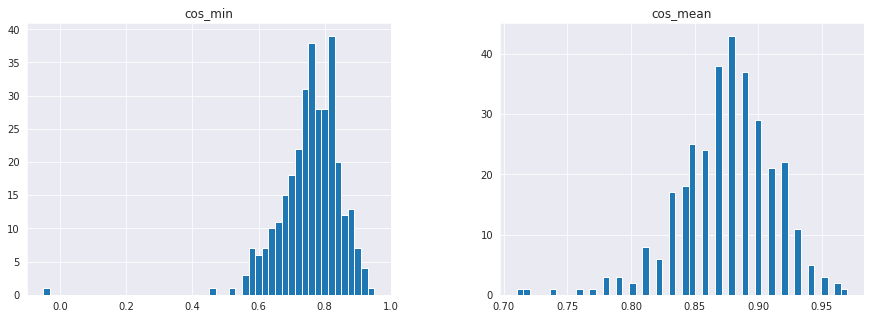

In [23]:
# TEST FOR LESSER NOISE
topic_info[['cos_min', 'cos_mean']].hist(figsize= (15,5), bins=50)
plt.show()

In [25]:
joblib.dump(umap_embeddings, "./model/apr26_may2_train_umap_obj.joblib")
joblib.dump(cluster, "./model/apr26_may2_train_clusterer_obj.joblib")

['./model/apr26_may2_train_clusterer_obj.joblib']

**Topics are about:**


In [25]:
# combine natural id inside docs_df
docs_df = pd.merge(docs_df, train_df, how="left", left_on="Doc", right_on="clean_body")
docs_df.drop("clean_body", axis=1, inplace=True)

In [25]:
# contains natid, article body, assigned topic

full_train_topics = pd.merge(docs_df, topic_info, how="left", left_on="Topic", right_on="topic_num")
full_train_topics.head(1)

,Doc,Topic,Doc_ID,content_natid,topic_num,topic_words,Size,cos_min,cos_mean
0,"10 robot vacuums that clean so you dont have to. if youre like most people, vacuuming is low on your list of favorite chores. you can avoid cleaning, or enlist the aid of a robot vacuum to clean your home autonomously. the best robot vacuums are ...",-1,0,blogandpostid/blog/post/4983-5ea87d15960ddf000681c604,-1,"remote, age, businesses, leaders, workers, water",1946,-0.05,0.71


In [26]:
# contains natid, article body, assigned topic

full_train_topics = pd.merge(docs_df, topic_info, how="left", left_on="Topic", right_on="topic_num")
full_train_topics.head(1)

,Doc,Topic,Doc_ID,strength,content_natid,topic_num,topic_words,Size,cos_min,cos_mean
0,"10 robot vacuums that clean so you dont have to. if youre like most people, vacuuming is low on your list of favorite chores. you can avoid cleaning, or enlist the aid of a robot vacuum to clean your home autonomously. the best robot vacuums are ...",-1,0,0.0,blogandpostid/blog/post/4983-5ea87d15960ddf000681c604,-1,"remote, age, businesses, leaders, workers, water",1946,-0.05,0.71


In [27]:
# TEST FOR LESSER NOISE
full_train_topics.to_csv(results_path+"MOD_STRGTH_apr26_may02_full_train_topics.csv", index=False)

In [29]:
# trained size 
topic_info.Size.describe()

count     323.000000
mean       22.408669
std       108.579164
min         5.000000
25%         7.000000
50%        11.000000
75%        19.000000
max      1946.000000
Name: Size, dtype: float64

<AxesSubplot:>

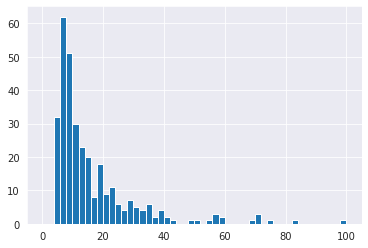

In [37]:
# trained size hist
topic_info.Size.hist(bins=50, range=(0,100))

* **Cluster trained object noise exploration**

[Closest soft clusters and cluster.labels_ do not match](https://stackoverflow.com/questions/44937157/comparing-hdbscan-labels-with-soft-cluster-results)

<AxesSubplot:ylabel='$\\lambda$ value'>

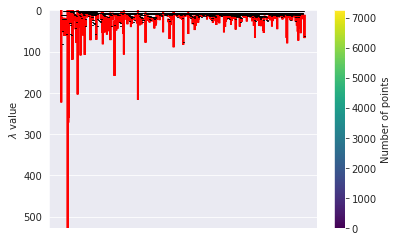

In [38]:
cluster.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

In [43]:
print(cluster.outlier_scores_)

threshold = pd.Series(cluster.outlier_scores_).quantile(0.7)
outliers = np.where(cluster.outlier_scores_ > threshold)[0]
print(len(outliers))
# doesnt look like outliers and noise is same

[0.11818307 0.71868587 0.00942961 ... 0.32977017 0.47314654 0.14900152]
2172


In [60]:
print(len(cluster.cluster_persistence_))
print(len(cluster.cluster_persistence_))

276


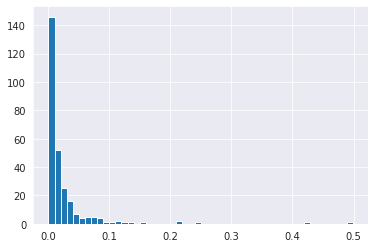

In [64]:
# not sure how to make use of this
plt.hist(cluster.cluster_persistence_, bins=50)
plt.show()

**Strength of labels (not the same as probability?)**
* labels_:ndarray, shape (n_samples, )
    * Cluster labels for each point in the dataset given to fit(). Noisy samples are given the label -1.
* probabilities_:ndarray, shape (n_samples, )
    * The strength with which each sample is a member of its assigned cluster. Noise points have probability zero; points in clusters have values assigned proportional to the degree that they persist as part of the cluster.

In [26]:
train_probs = pd.DataFrame({'trained_labels':cluster.labels_, 'probs': cluster.probabilities_})
train_probs = train_probs.groupby('trained_labels').agg({'probs':['min', 'mean', 'max']})
train_probs.columns = train_probs.columns.droplevel()
train_probs

,min,mean,max
trained_labels,,,
-1,0.000000,0.000000,0.0
0,0.037213,0.479764,1.0
1,0.811527,0.967251,1.0
2,0.054553,0.524114,1.0
3,0.048458,0.486613,1.0
...,...,...,...
317,0.890377,0.969850,1.0
318,0.607340,0.866227,1.0
319,0.435124,0.685373,1.0


<AxesSubplot:>

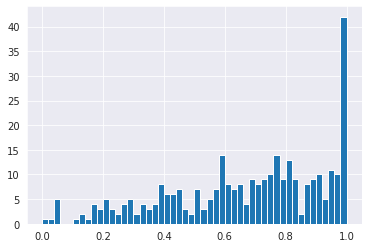

In [27]:
# can implement threshold to take docs only with high probbaility
train_probs['min'].hist(bins=50)

<AxesSubplot:>

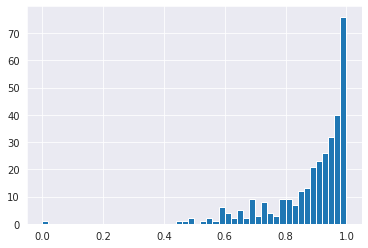

In [28]:
train_probs['mean'].hist(bins=50)

### --- Soft Clustering ---

* Data - Apr 26 - May 02 eligible articles and their trained topics

In [80]:
print(full_train_topics.shape)
full_train_topics[['Doc', 'Topic', 'Doc_ID', 'content_natid', 'topic_words']].head()

(7238, 9)


,Doc,Topic,Doc_ID,content_natid,topic_words
0,"10 robot vacuums that clean so you dont have to. if youre like most people, vacuuming is low on your list of favorite chores. you can avoid cleaning, or enlist the aid of a robot vacuum to clean your home autonomously. the best robot vacuums are ...",-1,0,blogandpostid/blog/post/4983-5ea87d15960ddf000681c604,"remote, age, businesses, leaders, workers, water"
1,"these 11 mattress toppers give you the bed of your dreams. while new pillows or a new set of sheets can do a lot to improve how you sleep at night, those small changes arent always enough if there are bigger issues at play, like bad alignment or ...",46,1,blogandpostid/blog/post/4983-5e8de2742c1bdd0006d26298,"mattress topper, weighted blanket, cotton, duvet, sheet set, foam"
2,"wayfairs biggest sale of the year is officially here. thanks to the pandemic, most of us have spent the past year at home, forced to stare at the same worn-in couch, threadbare arm chair and sparse wall art. so if youre feeling like its time for ...",56,2,blogandpostid/blog/post/4983-60786128cce52e000682cdc4,"hair clippers, garden, tertill, best hair, kitchen, june oven"
3,"apple ios 14.5 released: massive iphone update with cool features & important fixes. april 28 update below. this post was first published on april 26. apples latest iphone software update is with us. oh, finally. its been a long time coming and i...",60,3,blogandpostid/blog/post/4896-607ebc0543bb4800062917c1,"photos, airpods, ubuntu, iphone, windows, linux"
4,"apple airtag: all you need to know about the game-changing new gadget. april 28 update below. this post was first published on monday, april 26. apples all-new product category, airtag, is with us in a matter of days. its a small, cute wireless t...",60,4,blogandpostid/blog/post/4896-60873ceb2bbacb0006be2df8,"photos, airpods, ubuntu, iphone, windows, linux"


**From API Docs:**

* Traditional clustering - assigns each point in a data set to a cluster (or to noise). This is a hard assignment; there are no mixed memberships. A point near the edge of one cluster and also close to a second cluster, is just as much “in the first cluster” as in the second cluster. So, if the clustering algorithm supports noise assignments, then points are simply assigned as “noise”. We are left with no idea as to which, if any cluster, they might have just missed the cut on being in
    *  Uses hierarchical clustering
    

* Soft Clustering - here points are not assigned cluster labels, but are instead assigned a vector of probabilities. This allows points to potentially be a mix of clusters. By looking at the vector a data scientist can discern how strongly a point is in a cluster, and which other clusters it is related to. 
    * Uses conditional probabilities
    
    
* Soft cluster probabilities are not generated with the same principle as clustering happened

In [ ]:
# this gives probabilities for above df
temp = hdbscan.prediction.all_points_membership_vectors(cluster)

In [50]:
print('Total topics including noise', len(docs_df.Topic.unique()))
print('Vector size of Probability of row being in a cluster (excluding noise)', len(temp[0]))

Total topics including noise 323
Vector size of Probability of row being in a cluster (excluding noise) 322


In [51]:
# soft clustering

closest_clusters = [np.argmax(x) for x in temp]

probs = []
for i in range(len(temp)):
    probs.append(temp[i][closest_clusters[i]])
print(len(probs))

inspect = docs_df[['Doc', 'Doc_ID', 'Topic']].copy()
inspect['closest_clusters'] = closest_clusters
inspect['closest_cluster_prob'] = probs

7238


In [39]:
# TRIAL - SEE POINTS WITH CLOSE TO 2 CLUSTER
def top_two_probs_diff(probs):
    sorted_probs = np.sort(probs)
    return sorted_probs[-1] - sorted_probs[-2]

# Compute the differences between the top two probabilities
diffs = np.array([top_two_probs_diff(x) for x in temp])
# Select out the indices that have a small difference, and a larger total probability
mixed_points = np.where((diffs < 0.001) & (np.sum(temp, axis=1) > 0.5))[0]

print(len(diffs))
print(diffs[0])

docs_df[docs_df.index.isin(mixed_points)].Topic.value_counts()

# TRIAL - JUST SEE ARGMAX OUTPUTS
print("===TRAINING===")
print(np.argmax(temp[0]))
print(temp[0][48])
print()
print(np.argmax(temp[1]))
print(temp[1][46])
print()

# TRIAL - ASSIGN CLOSEST CLUSTERS AND SEE MISMATCH IN LABELS ISSUE
insp_noise = inspect[inspect.Topic==-1]
print(insp_noise[insp_noise.closest_cluster_prob>0.2].shape)
insp_noise[insp_noise.closest_cluster_prob>0.2].head(1)

print("Matching labels", inspect[inspect.Topic== inspect.closest_clusters].shape)
print("Non-Matching labels", inspect[inspect.Topic != inspect.closest_clusters].shape)

inspect[inspect.Topic != inspect.closest_clusters].Topic.value_counts()

inspect[inspect.Topic != inspect.closest_clusters].Topic.value_counts().sum()

# just 167 non-noise rows' soft clusters are not aligning with their orig assigned label - MISMATCH IS NOT HUGE ISSUE
inspect[(inspect.Topic != inspect.closest_clusters) & (inspect.Topic !=-1)].shape

# closest cluster probabilities for non-noise mismatches
inspect[(inspect.Topic != inspect.closest_clusters) & (inspect.Topic !=-1)].closest_cluster_prob.describe()

# closest cluster probabilities for noise 
inspect[(inspect.Topic != inspect.closest_clusters) & (inspect.Topic ==-1)].closest_cluster_prob.describe()

(18, 5)


,Doc,Doc_ID,Topic,closest_clusters,closest_cluster_prob
93,"10 years ago today, bitcoin creator satoshi nakamoto sent his final message. on april 26, 2011, bitcoin creator satoshi nakamoto sent his final emails to fellow developers in which he made clear he had moved on to other projects, at the time hand...",93,-1,189,0.228787


In [56]:
to_save = inspect[(inspect.Topic != inspect.closest_clusters) & (inspect.Topic ==-1)]
to_save = pd.merge(to_save, topic_info, how='left', left_on="closest_clusters", right_on="topic_num")
to_save = to_save[['Doc', 'Doc_ID', 'Topic', 'closest_clusters', 'closest_cluster_prob', 'topic_words']]
# to_save.to_csv("softcluster_label_mismatch_may03_trained.csv", index=False)

* Assign closest clusters as topics to articles and inspect the noise articles

In [59]:
to_save.head(3)

,Doc,Doc_ID,Topic,closest_clusters,closest_cluster_prob,topic_words
0,"10 robot vacuums that clean so you dont have to. if youre like most people, vacuuming is low on your list of favorite chores. you can avoid cleaning, or enlist the aid of a robot vacuum to clean your home autonomously. the best robot vacuums are ...",0,-1,48,0.029913,"sofa, furniture, inches, seating, living room, wall"
1,"two nightmare scenarios for bitcoin. cryptocurrencies could be damned if they do get government acceptance, and damned if they dont. yes, thats right, there is a route to oblivion whichever way the cookie crumbles. government crypto ban? heres th...",9,-1,224,0.059002,"ripple, kirkpatrick, ants, currency, xrp ledger, publicis"
2,"luminar partners with airbus on laser lidar sensors for robotic aircraft. luminar, a newly public maker of laser lidar sensors, is stepping beyond self-driving cars to partner with airbus advanced technology arm to determine if 3-d vision improve...",10,-1,235,0.032495,"million valuation, funding, headquarters san, ai, francisco founders, california founders"


**From API Docs:**
* Noise point will usually be assigned low probabilities of being in any cluster, but you can discern which clusters they are closer to, or even if they were very nearly part of a cluster.

Probabilities assigned to noise points:


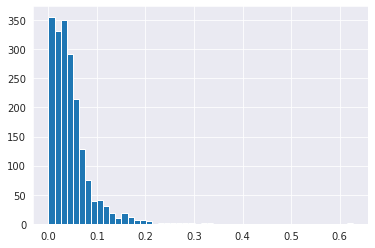

In [62]:
print("Probabilities assigned to noise points:")
inspect[inspect.Topic==-1].closest_cluster_prob.hist(bins=50)
plt.show()

| Metrics  | Threshold 0.3      | Threshold 0.15 |
| -----------| ----------- | ----------- |
| Number of noise articles that will get a topic | 7      | 59       |
| Quality of Topics assigned to noise articles | 5 - good, 2 - bad   | 30 - good, 29 - bad        |

* Threshold 0.15?

In [75]:
to_save[to_save.closest_cluster_prob>=0.15].tail(2)

,Doc,Doc_ID,Topic,closest_clusters,closest_cluster_prob,topic_words
1916,"how a distributed workforce can offer more opportunities. sergei anikin is chief technical officer at pipedrive , a global sales crm. only a few businesses had remote workforces before last year, but remote work is now normal across the world dri...",7118,-1,280,0.164314,"project management, scenario planning, flamini, focal issue, flat structure, ally"
1930,"the top 25 youtube vr videos of 2019. got a new holiday vr headset? immerse yourself in these standout vr videos from 2019. with the official launches of the oculus quest, valve index, varjo vr-1, and hp reverb headsets, 2019 was a big year for v...",7181,-1,42,0.157969,"torch lake, vr, trout, rivers, immersive, michigan"


* Observations:
    * Not a significant gain in assinging topics to noise articles, unless threshold is dropped very low (between 0 and 0.1) but then quality of assignment decreases 


* Drawback:
    * Its an experimental feature 
    * People have raised issues on inconsistent probabilities, i.e. point which made complete sense for being in a cluster was assigned low probability

In [88]:
pd.merge(inspect[(inspect.Topic !=-1)], topic_info[['topic_num', 'topic_words']], how='left', left_on="closest_clusters", right_on="topic_num").loc[3:4]

,Doc,Doc_ID,Topic,closest_clusters,closest_cluster_prob,topic_num,topic_words
3,"apple airtag: all you need to know about the game-changing new gadget. april 28 update below. this post was first published on monday, april 26. apples all-new product category, airtag, is with us in a matter of days. its a small, cute wireless t...",4,60,60,1.000000,60,"photos, airpods, ubuntu, iphone, windows, linux"
4,"these 10 cozy down alternative comforters make your bed feel extra luxurious. your bed should be your safe haven. your place to escape after a long dayor to curl up on a sunday morning when you have nothing to do but drink coffee in bed, engulfed...",5,46,46,0.288712,46,"mattress topper, weighted blanket, cotton, duvet, sheet set, foam"


* Probability distribution for non-noise articles

In [87]:
inspect[(inspect.Topic !=-1)].closest_cluster_prob.describe()

count    5292.000000
mean        0.517257
std         0.419583
min         0.001868
25%         0.106844
50%         0.344477
75%         1.000000
max         1.000000
Name: closest_cluster_prob, dtype: float64

* **Noise cossine similarity experiement**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [206]:
eligible_topics = sorted(docs_df.Topic.unique())[1:]

In [207]:
exp_dict={}
for topic_num in eligible_topics:

    topic_group = docs_df[docs_df.Topic== topic_num]
    #     print(topic_group.shape)
    
    # grab all articles of given topic
    group_embeddings = [train_embeds[i] for i in list(topic_group.index)] # use Doc_ID as index instead - less error prone

    #     print(len(group_embeddings))
    exp_dict[topic_num] =np.mean(group_embeddings, axis=0)

In [208]:
print(to_save.shape)
to_save_embeds =  [train_embeds[i] for i in list(to_save.Doc_ID)]
print(len(to_save_embeds))

(2307, 10)
2307


In [229]:
print(len(cosine_similarity([to_save_embeds[0]], list(exp_dict.values()))[0]))
print(np.argmax(cosine_similarity([to_save_embeds[0]], list(exp_dict.values()))[0]))

276
52


In [232]:
len(to_save_embeds)

2307

In [233]:
cosine_topics = []
for noise in to_save_embeds:
    cosine_topics.append(np.argmax(cosine_similarity([noise], list(exp_dict.values()))[0]))

In [235]:
print(len(cosine_topics))
print((cosine_topics[0]))

2307
52


In [237]:
to_save["cosine_topics"] = cosine_topics

In [240]:
to_save.head(1)

,Doc,Doc_ID,Topic,closest_clusters,closest_cluster_prob,topic_num,topic_words,Size,cos_min,cos_mean,cosine_topics
0,"10 robot vacuums that clean so you dont have to. if youre like most people, vacuuming is low on your list of favorite chores. you can avoid cleaning, or enlist the aid of a robot vacuum to clean your home autonomously. the best robot vacuums are ...",0,-1,45,0.042042,45,"sofa, furniture, inches, seating, living room, coffee table",5,0.73,0.86,52


In [241]:
topic_info.head(1)

,topic_num,topic_words,Size,cos_min,cos_mean
0,-1,"women, age, remote, businesses, human, leaders",2159,-0.05,0.71


In [245]:
final_to_save = pd.merge(to_save, topic_info[['topic_num', 'topic_words']], how='left', left_on="cosine_topics", right_on="topic_num")
final_to_save.head(1)

,Doc,Doc_ID,Topic,closest_clusters,closest_cluster_prob,topic_num_x,topic_words_x,Size,cos_min,cos_mean,cosine_topics,topic_num_y,topic_words_y
0,"10 robot vacuums that clean so you dont have to. if youre like most people, vacuuming is low on your list of favorite chores. you can avoid cleaning, or enlist the aid of a robot vacuum to clean your home autonomously. the best robot vacuums are ...",0,-1,45,0.042042,45,"sofa, furniture, inches, seating, living room, coffee table",5,0.73,0.86,52,52,"cast iron, toaster, grill, fridge, kitchen, air fryer"


In [247]:
final_to_save[final_to_save.closest_clusters==final_to_save.cosine_topics].shape

(765, 13)

In [248]:
final_to_save.to_csv("softcluster_plus_cosine_label_noise_only_may03_trained.csv", index=False)

* **Predict new points/articles - May 3**

In [39]:
umap_embeddings = joblib.load("./model/apr26_may2_train_umap_obj.joblib")
cluster = joblib.load("./model/apr26_may2_train_clusterer_obj.joblib")

print(umap_embeddings)
print()
print(cluster)

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.0, random_state=42)

HDBSCAN(min_samples=4, prediction_data=True)


**Note:** 
* There will be articles read between Apr 26 - May 02 (training set), which will also be read on May 03. 
* These common articles present in prediction set, will get the same topic cluster as before

**For now:**
* Predict on whole of may03

In [40]:
# dimensionality reduction
umap_embeddings_may03 = umap_embeddings.transform(may03_art_embed) # min_dist=0.0,

print("Training input shape:", umap_embeddings.embedding_.shape)
print("Prediction input shape:", umap_embeddings_may03.shape) #takes a min

Training input shape: (7238, 2)
Prediction input shape: (4199, 2)


In [41]:
# predict

may03_test_labels, may03_strengths = hdbscan.approximate_predict(cluster, umap_embeddings_may03)

print(len(may03_test_labels))
print(len(set(may03_test_labels)))

4199
310


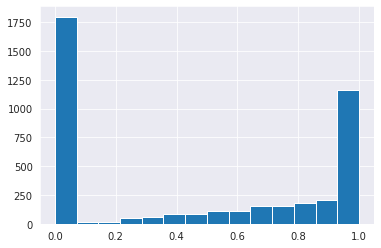

In [42]:
plt.hist(may03_strengths, bins='auto')
plt.show()

* Exploring prediction strength for thresholding

In [43]:
print(len(may03_test_labels))
print(len(may03_strengths))
print(type(may03_strengths))

4199
4199
<class 'numpy.ndarray'>


According to API:

* labels: Cluster labels for each point in the dataset given to fit(). Noisy samples are given the label -1.
* probabilities: The strength with which each sample is a member of its assigned cluster. Noise points have probability zero; points in clusters have values assigned proportional to the degree that they persist as part of the cluster.

In [30]:
strength_exp = pd.DataFrame(zip(may03_test_labels, may03_strengths), columns=['Topic', 'Strength'])
strength_exp.head()

,Topic,Strength
0,42,0.861293
1,-1,0.000000
2,-1,0.000000
3,46,0.582528
4,-1,0.000000


In [31]:
strength_exp.groupby('Topic').agg({'Strength':['min', 'mean', 'max']})

Strength                    
            min      mean       max
Topic                              
-1     0.000000  0.000000  0.000000
 0     0.055268  0.476356  1.000000
 1     0.008874  0.170429  0.524824
 2     0.019150  0.506401  1.000000
 3     0.071058  0.416085  1.000000
...         ...       ...       ...
 269   0.442683  0.611525  0.906397
 270   0.610208  0.811518  1.000000
 272   0.694246  0.694246  0.694246
 273   0.433795  0.593477  0.855312
 274   0.813417  0.891079  1.000000

[260 rows x 3 columns]

In [32]:
# this gives for prediction data
temp_pred = hdbscan.prediction.membership_vector(cluster, umap_embeddings_may03)

In [33]:
print("===PREDICTION===")
print(np.argmax(temp_pred[0]))
print(temp[0][42])

===TRAINING===
45
0.04204195017308981

42
0.09385600636215856

===PREDICTION===
42
0.013022068414443252


In [44]:
# put topics in dataframe
may03_docs_df = may03[['clean_body']]
may03_docs_df.rename(columns={'clean_body':'Doc'}, inplace=True)
may03_docs_df["Topic"] = may03_test_labels

print("Distinct topics including -1 for noise", len(may03_docs_df.Topic.unique()))
print()
may03_docs_df.tail()

Distinct topics including -1 for noise 310



,Doc,Topic
4194,"alexander the great: gay or straight?. (one in a series of conversations between historians james romm and paul a. cartledge , editor and introduction-author, respectively, of the new landmark arrian: the campaigns of alexander , published by pan...",-1
4195,"mark zuckerberg joins the north american man-boy love association, and other adventures in facebook groups. my colleague kashmir hill congratulated facebook's mark zuckerberg earlier today on his increasingly savvy approach to talking about priva...",44
4196,"why reits make sense. michael gunzenhaeuser, a 59-year-old semiretired obstetrician in mansfield, ohio, has heard his share of real estate horror stories lately. friends who own rental apartments grousing about plumbers' bills and endless tenant ...",243
4197,brrr!. bill clinton recently brought up the idea that we might have to slow down the u.s. economy to cut back on greenhouse emissions in order to save the planet from global warming. less prosperity will be our salvation! putting aside the former...,-1
4198,"fact and comment. fantastic fiber future is here--but not in u.s. washington and the federal communications commission should look to south korea to see what the future could be like with true telecom deregulation. in the u.s. a t-1 line, which p...",190


In [45]:
may03_topic_sizes = extract_topic_sizes(may03_docs_df)

# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
may03_cossim_df = generate_all_cossim_metrics(may03_docs_df, umap_embeddings_may03)

# per topic - tier counts
tier_metric = may03_docs_df.join(may03[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info_may03 = pd.merge(pd.merge(may03_topic_sizes, 
                                        may03_cossim_df, how="inner", left_on="Topic", right_on = "topic_num"), 
                               iab_metric, on = "topic_num", how="inner")

topic_info_may03.drop('Topic', axis=1, inplace=True)

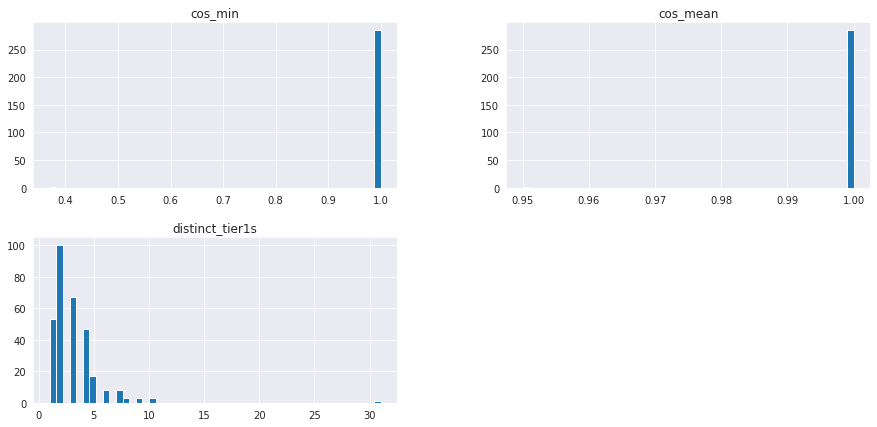

In [46]:
# TEST FOR LESSER NOISE
topic_info_may03[['cos_min', 'cos_mean', 'distinct_tier1s']].hist(figsize= (15,7), bins=50)
plt.show()

In [47]:
# combine natural id inside docs_df

may03_docs_df = pd.merge(may03_docs_df, may03, how="left", left_on="Doc", right_on="clean_body")
may03_docs_df.drop("clean_body", axis=1, inplace=True)

In [48]:
# combine topic_info_may03 with topic names

topic_info_may03 = pd.merge(topic_info_may03, top_n_words_df, how="left", on="topic_num").sort_values("topic_num")

In [49]:
pred_may03_inspect = pd.merge(may03_docs_df, 
         topic_info_may03, 
         how="left", 
         left_on="Topic", 
         right_on = "topic_num").drop('topic_num', axis=1)

In [51]:
topic_info_may03.Size.describe()

count     310.000000
mean       13.545161
std       101.228807
min         1.000000
25%         3.000000
50%         5.000000
75%         9.000000
max      1784.000000
Name: Size, dtype: float64

<AxesSubplot:>

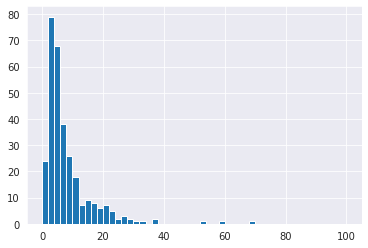

In [52]:
topic_info_may03.Size.hist(bins=50, range=(0, 100))

In [58]:
print(len(pred_may03_inspect.Topic.unique()))
print(pred_may03_inspect[pred_may03_inspect.Topic==-1].shape)

310
(1784, 15)


In [53]:
len(pred_may03_inspect[pred_may03_inspect.Topic!=-1].tier1.unique())

31

In [54]:
print(pred_may03_inspect[pred_may03_inspect.Topic==-1].shape)
pred_may03_inspect[pred_may03_inspect.Topic==-1].tier1.value_counts()

(1784, 15)


Other                       528
Business and Finance        335
Personal Finance            145
Technology & Computing      138
Medical Health              115
News and Politics            87
Video Gaming                 59
Travel                       43
Shopping                     42
Sports                       33
Careers                      23
Food & Drink                 22
Real Estate                  21
Education                    20
Style & Fashion              19
Automotive                   19
Healthy Living               18
Music and Audio              17
Television                   16
Science                      15
Home & Garden                14
Events and Attractions       12
Hobbies & Interests          10
Movies                        9
Family and Relationships      7
Books and Literature          6
Pop Culture                   5
Fine Art                      3
Content Channel               1
Religion & Spirituality       1
Pets                          1
Name: ti